<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2024/blob/main/Module_7/MidTerm_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MidTerm - 2 for the Fall 2024 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin

Special point:
- ChatGPT will augment your power as a coder
- If and only if you know what you want to accomplish!

# 1.Out-of-distribution effects

Explore the out of distribution effects in VAE.
- Build the VAE or AE denoiser
- Train it on the digits [0-5]
- Quantufy performance on the digits that it was trained on (e.g. vis SSID of ground truth vs reconstruction as a function of noise)
- Quantify performance for digits [6-9]

# 2.Explainable ML

- Build the classified for the fashion MNIST data set
- Use LIME or SHAP to explain the predictions

# 3.Molecular discovery

- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh, research.aghosh@gmail.com

## Install RDkit and Selfies

In [1]:
!pip install rdkit-pypi
!pip install selfies --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 62.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

import torch
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize

import selfies as sf

In [3]:
def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)

def parse_xyz(filename):
    """
    Parses QM9 specific xyz files.
    :param filename: str path to file
    :return:
    """
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    harmonic_vibrational_frequencies = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 2:
                harmonic_vibrational_frequencies = [float(i) for i in line.split()]
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    result = {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'harmonic_oscillator_frequencies': harmonic_vibrational_frequencies,
        'smiles': smiles,
        'inchi': inchi
    }
    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties = dict(zip(scalar_property_labels, scalar_properties))
    result.update(scalar_properties)
    return result

## Download the data

In [4]:
!gdown https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF

Downloading...
From (original): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF
From (redirected): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF&confirm=t&uuid=3b9193e7-2f09-41d4-87de-acf420558f14
To: /content/dsgdb9nsd.xyz.tar.bz2
100% 86.1M/86.1M [00:00<00:00, 91.8MB/s]


Generate lists of SMILE strings and append with properties that we can directly retrieve from the QM9 dataset

What are SMILES and when were they invented (note that ChatGPT is unlikely to produce the correct citation - so Wikipedia can help)?

Answer:

In [5]:
!mkdir /content/Molecules
!tar -C Molecules -xvf /content/dsgdb9nsd.xyz.tar.bz2

Streaming output truncated to the last 5000 lines.
dsgdb9nsd_128886.xyz
dsgdb9nsd_128887.xyz
dsgdb9nsd_128888.xyz
dsgdb9nsd_128889.xyz
dsgdb9nsd_128890.xyz
dsgdb9nsd_128891.xyz
dsgdb9nsd_128892.xyz
dsgdb9nsd_128893.xyz
dsgdb9nsd_128894.xyz
dsgdb9nsd_128895.xyz
dsgdb9nsd_128896.xyz
dsgdb9nsd_128897.xyz
dsgdb9nsd_128898.xyz
dsgdb9nsd_128899.xyz
dsgdb9nsd_128900.xyz
dsgdb9nsd_128901.xyz
dsgdb9nsd_128902.xyz
dsgdb9nsd_128903.xyz
dsgdb9nsd_128904.xyz
dsgdb9nsd_128905.xyz
dsgdb9nsd_128906.xyz
dsgdb9nsd_128907.xyz
dsgdb9nsd_128908.xyz
dsgdb9nsd_128909.xyz
dsgdb9nsd_128910.xyz
dsgdb9nsd_128911.xyz
dsgdb9nsd_128912.xyz
dsgdb9nsd_128913.xyz
dsgdb9nsd_128914.xyz
dsgdb9nsd_128915.xyz
dsgdb9nsd_128916.xyz
dsgdb9nsd_128917.xyz
dsgdb9nsd_128918.xyz
dsgdb9nsd_128919.xyz
dsgdb9nsd_128920.xyz
dsgdb9nsd_128921.xyz
dsgdb9nsd_128922.xyz
dsgdb9nsd_128923.xyz
dsgdb9nsd_128924.xyz
dsgdb9nsd_128925.xyz
dsgdb9nsd_128926.xyz
dsgdb9nsd_128927.xyz
dsgdb9nsd_128928.xyz
dsgdb9nsd_128929.xyz
dsgdb9nsd_128930.xyz
dsgd

In [6]:
smiles = []
enthalpy = []
u0 = []
u = []
g = []
alpha = []
r2 = []
mu = []

#may need to change the path
filenames = glob.glob('/content/Molecules/*.xyz')

#may need to go through the full range
for fid in range(5000):
    x = parse_xyz(filenames[fid])
    smiles_loc = x['smiles']
    enthalpy_loc = x['h']
    dipole_moment = x['mu']
    homo_loc = x['homo']
    lumo_loc = x['lumo']
    gap_loc = x['gap']
    zpve_loc = x['zpve']
    u0_loc = x['u0']
    u_loc = x['u']
    g_loc = x['g']
    alpha_loc = x['alpha']
    r2_loc = x['r2']
    smiles.append(smiles_loc)
    mu.append(dipole_moment)
    enthalpy.append(enthalpy_loc)
    u0.append(u0_loc)
    u.append(u_loc)
    g.append(g_loc)
    alpha.append(alpha_loc)
    r2.append(r2_loc)

Let's compute few basic features and put together a dataset. Features we compute:
- molecular weight,
- topological polar surface area,
- molar log P,
- number of hydrogen bond donors,
- acceptors,
- valence electrons,
- maximum partial charge,
- minimum partial charge,
- number of rotatable bonds,
- number of ring counts,
- number of stereocenters

In [7]:
mol_wt, tpsa, logp_ml, hbd, hba  = [], [], [], [], []
vale, partialcg_max, partialcg_min, rotbd, ringct, stereoct = [], [], [], [], [], []

for i in range(len(smiles)):
    m = Chem.MolFromSmiles(smiles[i])
    mol_wt_l = Descriptors.ExactMolWt(m)
    tpsa_l, logp_l = Descriptors.TPSA(m), Descriptors.MolLogP(m)
    hbd_l, hba_l = Descriptors.NumHDonors(m), Descriptors.NumHAcceptors(m)
    vale_l = Descriptors.NumValenceElectrons(m),
    partialcharge_max_l, partialcharge_min_l = Descriptors.MaxPartialCharge(m), Descriptors.MinPartialCharge(m)
    rotbd_l = Descriptors.NumRotatableBonds(m)
    ring_ct, stereo_cent = Descriptors.RingCount(m), rdMolDescriptors.CalcNumAtomStereoCenters(m)

    mol_wt.append(mol_wt_l)
    tpsa.append(tpsa_l)
    logp_ml.append(logp_l)
    hbd.append(hbd_l)
    hba.append(hba_l)
    vale.append(vale_l)
    partialcg_max.append(partialcharge_max_l)
    partialcg_min.append(partialcharge_min_l)
    rotbd.append(rotbd_l)
    ringct.append(ring_ct)
    stereoct.append(stereo_cent)

New dataset with few features with SMILE strings

In [8]:
df = pd.DataFrame({'smiles': smiles, 'mole_logp': logp_ml,'tpsa': tpsa, 'mol_wt' : mol_wt,
                   'hbd': hbd, 'hba':hba, 'valencee':vale, 'max_partialcharge':partialcg_max, 'min_partialcharge':partialcg_min,
                   'rotatablebd':rotbd, 'ringct':ringct, 'stereocent': stereoct, 'dipole_moment':mu})

In [9]:
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
0,CC(C)(O)CC#CC=O,0.34970,37.30,126.068080,1,2,"(50,)",0.192291,-0.389478,1,0,0,4.3345
1,N=C1CN=C(NC=O)N1,-1.33113,77.34,126.054161,3,3,"(48,)",0.213311,-0.313046,1,1,0,3.5219
2,C1NC1C1=CN=NN1,-0.55100,63.51,110.059246,2,3,"(42,)",0.073876,-0.305580,1,2,1,5.9345
3,CNC(=O)C1OCC=C1,-0.31260,38.33,127.063329,1,2,"(50,)",0.252396,-0.360204,1,1,1,3.1318
4,CC1(C)C2OC1C21CO1,0.56260,21.76,126.068080,0,2,"(50,)",0.144736,-0.367236,0,4,2,3.2566
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CC(=O)C(CO)OC=O,-0.89070,63.60,132.042259,1,4,"(52,)",0.293382,-0.454093,4,0,1,4.9680
4996,N=C1NN=CC=C1C#N,-0.23915,76.32,120.043596,2,3,"(44,)",0.156366,-0.282207,0,1,0,5.1942
4997,CC1C2(O)CC=CC12C,1.33340,20.23,124.088815,1,1,"(50,)",0.080727,-0.388344,0,2,3,1.3309
4998,CC(C)(CO)C#CC#C,0.64150,20.23,122.073165,1,1,"(48,)",0.059160,-0.394818,1,0,0,1.4537


## Convert SMILEs to SELFIEs

As an excercise, read the SELFIES paper (https://github.com/aspuru-guzik-group/selfies) and describe the difference between SMILES and SELFIEs

Answer:

In [10]:
smiles

['CC(C)(O)CC#CC=O',
 'N=C1CN=C(NC=O)N1',
 'C1NC1C1=CN=NN1',
 'CNC(=O)C1OCC=C1',
 'CC1(C)C2OC1C21CO1',
 'OC1(COCOC1)C=O',
 'CC1CN2CC1C2C=O',
 'NC1=NC(=O)N=C(O)O1',
 'O=C1NC2CC(C2)O1',
 '[NH3+]CC(=O)NCC([O-])=O',
 'CC1(CC2(O)CC12)C#C',
 'COC(=O)CCC#N',
 'CCN1N=C(C)NC1=O',
 'CNC(=O)NC(C)C#C',
 'O=C1C2CCC3CC2C13',
 'CC1(CC1)C1CCCC1',
 'NC1=NC(=CN1)C#N',
 'CN1C2C3C1COC23C',
 'CC1(C)OC(=O)CC1=O',
 'OC1=C(CC#C)NC=C1',
 'CCC1C2C3CN3C12C',
 'CC(O)CC1=CN=CO1',
 'CC1=NC(N)=C(CO)N1',
 'CC(O)C1OC1CCO',
 'CCC(=O)C#N',
 'COC12CC(C)C1C2O',
 'O=C1CCC2OCC12',
 'CC12C3CC1C(C3)C2=O',
 'OCC(O)C1CN1',
 'CC1OC1C12CN1CC2',
 'O=C1NC2CC2C=C1',
 'NC1=C(O)N=CC(=O)O1',
 'OC12C3CCC11OC2C31',
 'N=C1NC(=O)C=NO1',
 'CC1(C)C2CC1(O)CO2',
 'N#CCCOCC1CN1',
 'CC1C2CC1C1CC21',
 'CC#CC(=O)CC(N)=O',
 'CCOC1C2C3CC2C13',
 'O=C1C2CC1N1CCC21',
 'CC1C(C)C1(C)C1CO1',
 'O=CNC1CC(=O)C=C1',
 'CC1C2C=CC3CC2C13',
 'CC(C)C1C(O)CC1=O',
 'CC12COC(CO1)C2=O',
 'O=C1CC23CCC2(C1)N3',
 'CC12CNC(C1)C(=N)O2',
 'CN1N=CC2=C1NN=C2',
 'CC1=CC(O)COCC1

The SELFIES have some limitations on acceptable bonding. So we refine the data set to remove the molecules that do not fit into supported semantic constraints.

In [11]:
selfies_dataset = []
error_smiles = []

for i in range(len(smiles)):
    try:
        local_sf = sf.encoder(smiles[i])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(smiles[i])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

Error encoding SMILES at index 51: input violates the currently-set semantic constraints
	SMILES: NC1=CC=C(O1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2507: input violates the currently-set semantic constraints
	SMILES: CC1=NOC(=C1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 3020: input violates the currently-set semantic constraints
	SMILES: CC1=C(ON=N1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 3690: input violates the currently-set semantic constraints
	SMILES: CN1C=NC(=C1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 4502: input violates the currently-set semantic constraints
	SMILES: CC1=CC=C(O1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]



Let's see what these molecules are....

In [12]:
error_smiles_set = set(error_smiles)
error_smiles_set

{'CC1=C(ON=N1)N(=O)=O',
 'CC1=CC=C(O1)N(=O)=O',
 'CC1=NOC(=C1)N(=O)=O',
 'CN1C=NC(=C1)N(=O)=O',
 'NC1=CC=C(O1)N(=O)=O'}

... how many of them are there

In [13]:
df['smiles'].isin(error_smiles_set).sum()

5

And remove them from the dataframe

In [14]:
df_filtered = df[~df['smiles'].isin(error_smiles_set)]
df_filtered.tail(5)

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
4995,CC(=O)C(CO)OC=O,-0.89070,63.60,132.042259,1,4,"(52,)",0.293382,-0.454093,4,0,1,4.9680
4996,N=C1NN=CC=C1C#N,-0.23915,76.32,120.043596,2,3,"(44,)",0.156366,-0.282207,0,1,0,5.1942
4997,CC1C2(O)CC=CC12C,1.33340,20.23,124.088815,1,1,"(50,)",0.080727,-0.388344,0,2,3,1.3309
4998,CC(C)(CO)C#CC#C,0.64150,20.23,122.073165,1,1,"(48,)",0.059160,-0.394818,1,0,0,1.4537
4999,CC1CC2OC2(C1)C#N,1.07748,36.32,123.068414,0,2,"(48,)",0.180437,-0.349964,0,2,3,4.3995


Now, let's generate one-hot encodings.

In [15]:
#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

np.array(one_hot_vectors).shape

(4995, 21, 26)

Explore the code segment above. What is:
- alphabet
- symbol_to_idx
- what are the dimensionalities of the np.array(one_hot_vectors).shape

Answer:

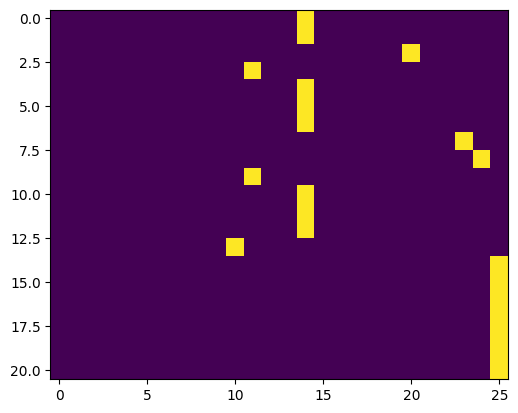

In [16]:
plt.imshow(np.array(one_hot_vectors)[310,:,:])

Now, let's explore the properties of the latent space of this dataset. Using ChaGPT:
- Write the AE using the encoded smiles as an input with 2D latent space
-  Visualize the latent distribution and representation
- Experiment with difefrent attributes from data frame as labels, and see how they are distirbuted in latent space

Do the same with the VAE, also with 2D latent space

Write the VAE with the 10D latent space. Suggest an approach to visualize the latent space

Describe the difference between AE and VAE latent distirbutions

Answer:

Explore the variability of
- dipole momentum,
- number of rings
- mole log P over latent spaces.
What conclusions can you make?